In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

# Set plot style
plt.style.use('bmh')

In [2]:
# Calculate the equilibrium point
def equilibrium(y):
    y1 = y[:-1].reshape(-1, 1)
    y1_ = y[1:].reshape(-1, 1)
    reg = LinearRegression().fit(y1, y1_)
    a = reg.intercept_[0]
    b = reg.coef_[0][0]
    y_lim = a / (1 - b)
    return y_lim

# Exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit the exponential function curve
def exp_fit(y):
    n = len(y)
    x = np.arange(n)
    popt,_ = curve_fit(exponential_func, x, y, maxfev=5000, method='dogbox')
    ycurve = exponential_func(x, *popt)
    return ycurve

# Calculate the average derivatives
def calculate_average_derivative(y):
    derivatives = np.gradient(y)
    average_derivative = np.mean(derivatives)
    return average_derivative

In [3]:
# Read and store result files
smape = pd.read_csv('/data/results.csv',
                      parse_dates=[0], index_col=0)

xdata = smape.index
ydata = np.array(smape.mean(axis=1))

# Define the first outliers
delta = 10

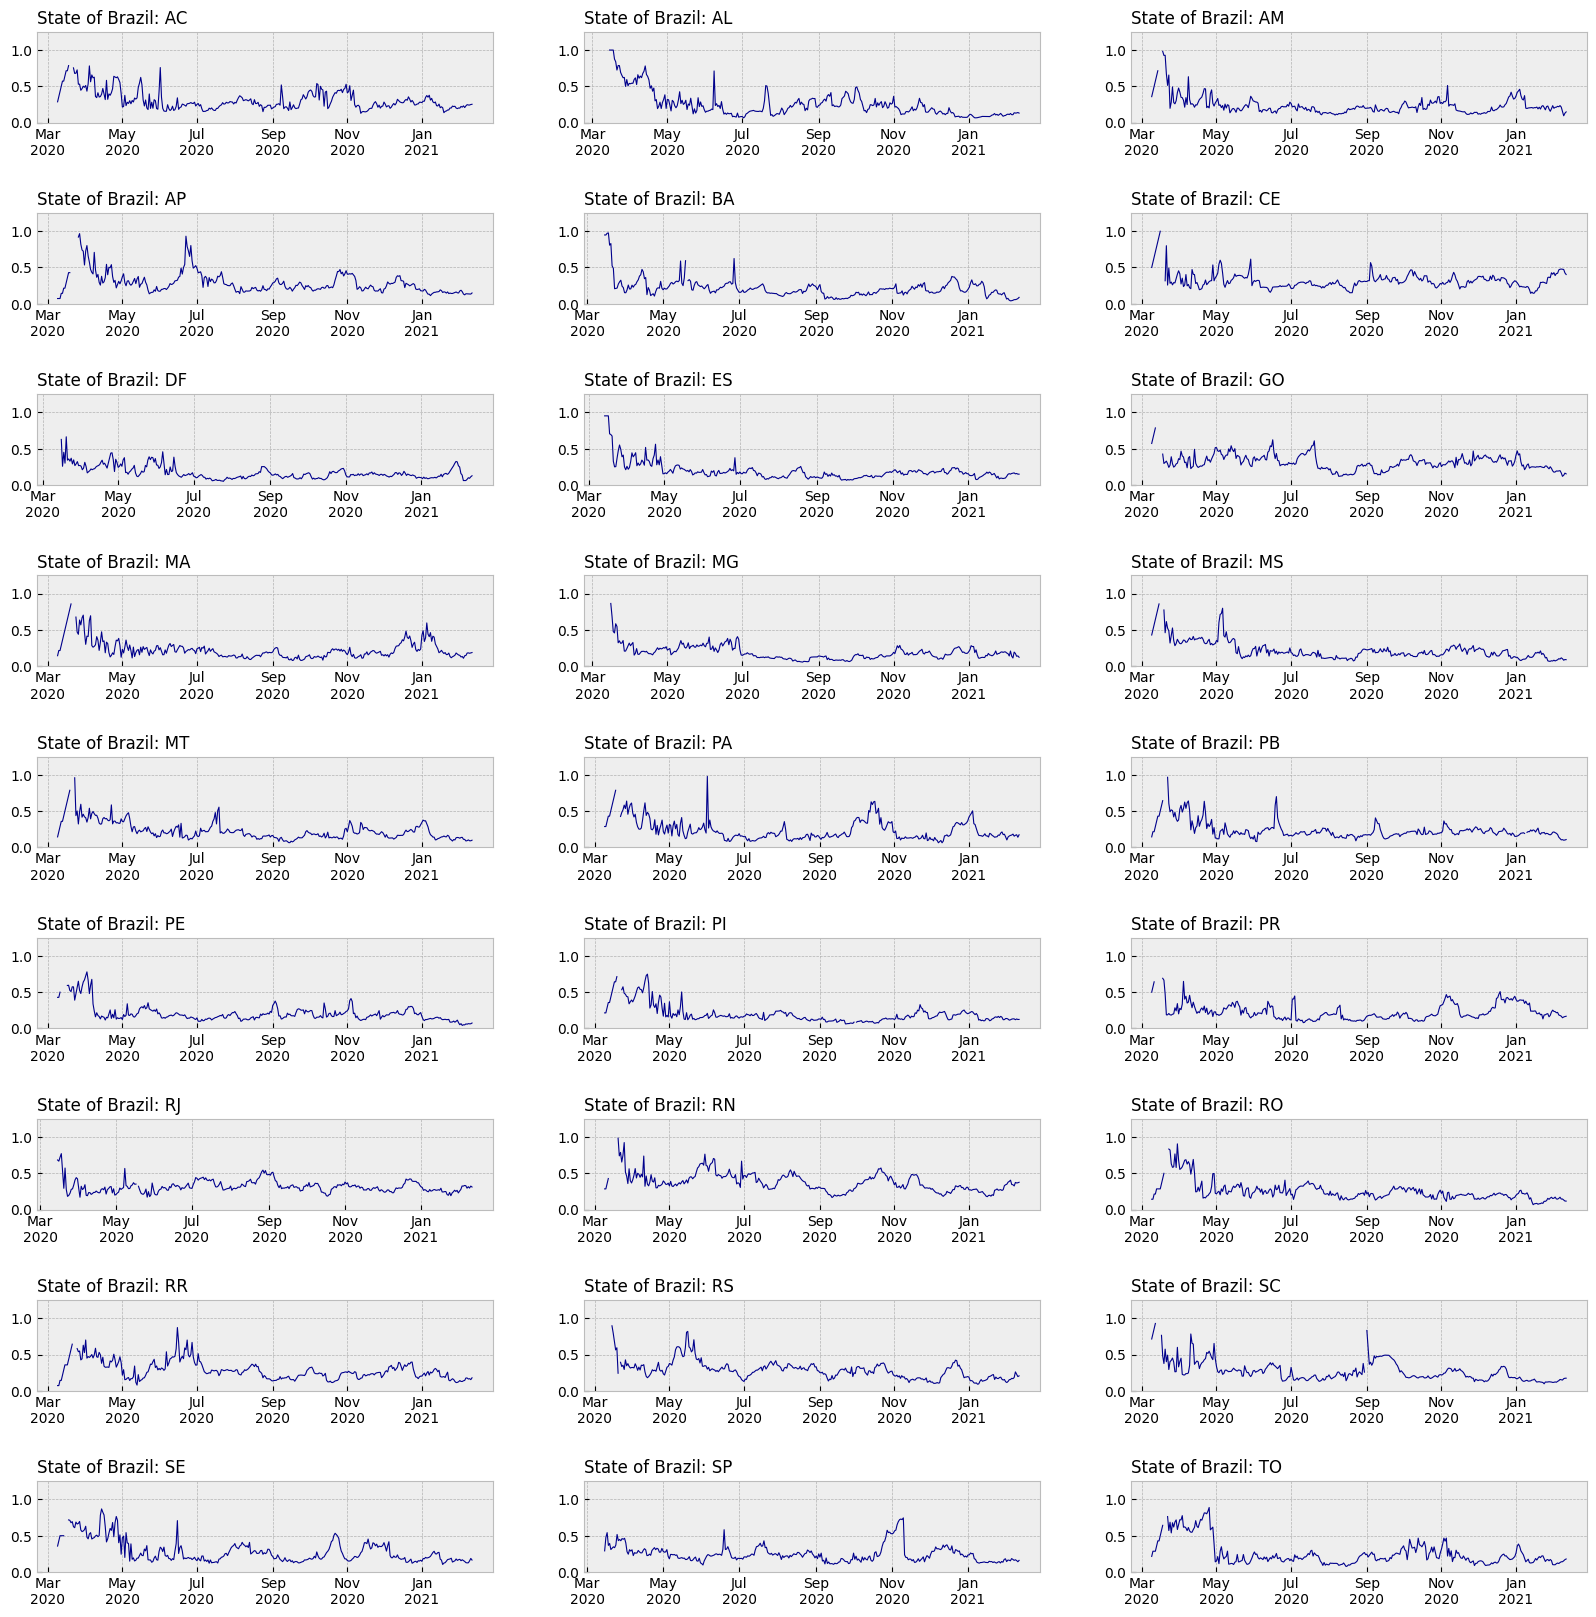

In [4]:
# Plot individual results
plt.figure(figsize=(20, 20))
for i in range(len(smape.columns)):
    plt.subplot(9, 3, i+1)
    plt.plot(smape.iloc[:, i], color='darkblue', linewidth=0.8)
    plt.title('State of Brazil: {}'.format(smape.columns[i]),
              loc='left', fontsize=12)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, 1.25)
    plt.subplots_adjust(hspace=1.0)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
plt.savefig('/graphs/Fig4.png', dpi=600)
plt.show()

In [5]:
# Summary statistics
print(smape.describe().T)
pd.DataFrame(smape.describe().T).to_csv('/data/statistics.csv')

    count      mean       std       min       25%       50%       75%  \
AC  337.0  0.310647  0.133549  0.126921  0.218911  0.270374  0.359664   
AL  335.0  0.253174  0.185035  0.064116  0.127003  0.203959  0.300019   
AM  337.0  0.233743  0.119683  0.093035  0.160615  0.206779  0.260418   
AP  335.0  0.287887  0.149704  0.071429  0.191033  0.249326  0.345327   
BA  333.0  0.212698  0.129959  0.039819  0.144310  0.192077  0.251348   
CE  337.0  0.319397  0.109986  0.142870  0.251148  0.301915  0.358369   
DF  334.0  0.173093  0.101241  0.048797  0.107891  0.143989  0.215919   
ES  335.0  0.189922  0.126716  0.062475  0.121888  0.165238  0.200796   
GO  336.0  0.314200  0.108141  0.117888  0.249064  0.302065  0.371700   
MA  337.0  0.226027  0.125788  0.076579  0.144674  0.190748  0.260104   
MG  334.0  0.188084  0.105010  0.054637  0.122572  0.166685  0.233121   
MS  337.0  0.218092  0.128960  0.065701  0.135330  0.183345  0.248395   
MT  337.0  0.227776  0.123705  0.062974  0.140413  

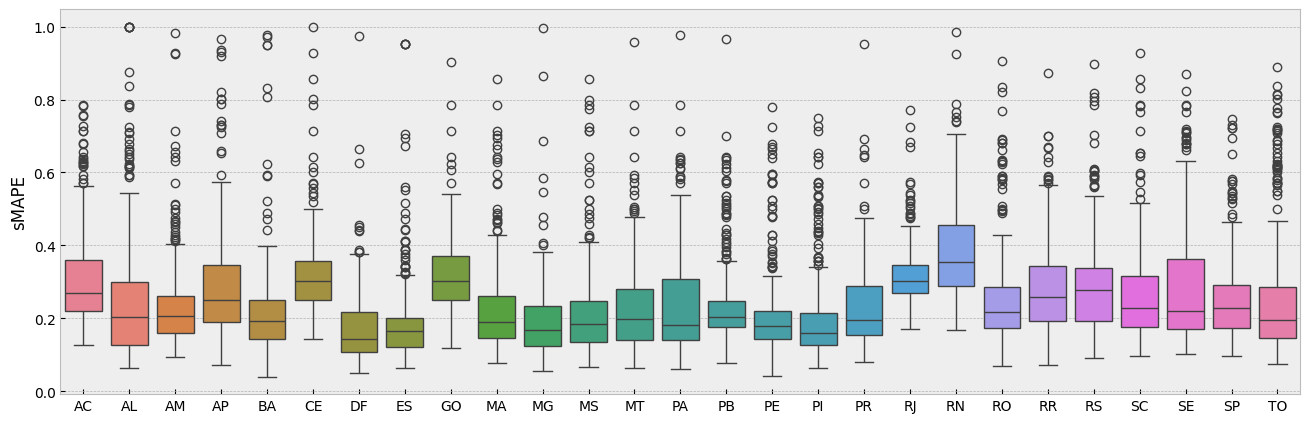

In [6]:
# Plot results boxplot
plt.figure(figsize=(16,5))
sns.boxplot(data=smape)
plt.ylabel('sMAPE')
plt.savefig('/graphs/Fig5.png', dpi=600)
plt.show()

In [7]:
# Fit the curve and calculate the equilibrium point
y_lim = equilibrium(ydata)
exp_model = exp_fit(ydata)
total_dados = smape.mean(axis=1)

# Define the equilibrium point in the results
precision = 3
point = np.where(np.round(exp_model - y_lim, precision) < 0)[0][0] - 1
poly_min_y = exp_model[point]
poly_min_X = total_dados.index[point]
poly_min_text = poly_min_X.strftime('%Y-%m-%d').format()

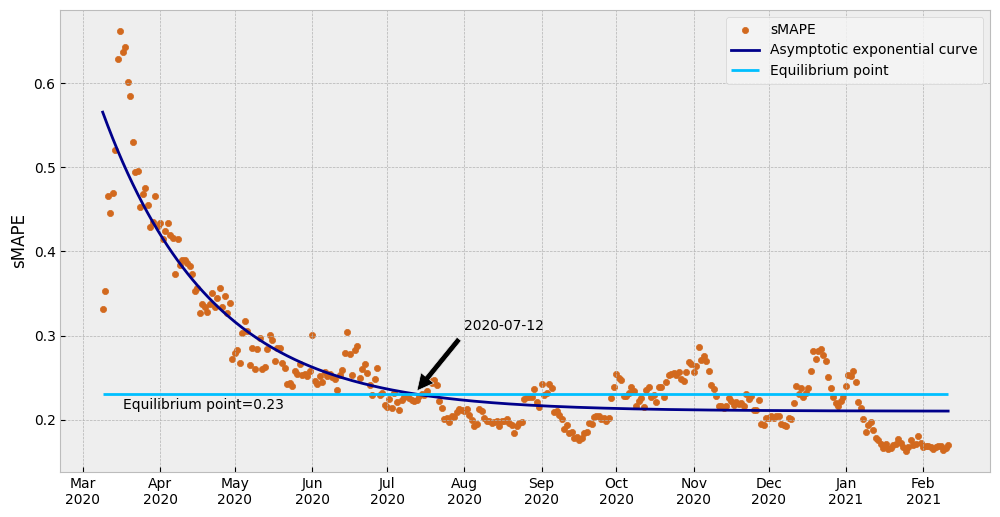

In [8]:
# Plot the exponential asymptotic curve
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(total_dados.index, total_dados.values, label='sMAPE', color='chocolate', s=20)
ax.plot(total_dados.index, exp_model, label='Asymptotic exponential curve', color='darkblue')
ax.hlines(y_lim, total_dados.index.min(), total_dados.index.max(), color='deepskyblue', label='Equilibrium point')
ax.annotate('Equilibrium point=%.2f' % y_lim, xy=(45, 45), xycoords='axes points')
ax.annotate(poly_min_text, xy=(poly_min_X, poly_min_y), xycoords='data',
             xytext=(348, 110), textcoords='axes points',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right', verticalalignment='top')
ax.set_ylabel('sMAPE')
ax.legend(facecolor='whitesmoke')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
plt.savefig('/graphs/Fig6.png', dpi=600)
plt.show()

In [9]:
# Calculate the average derivatives and equilibrium points from all curves
derivatives = []
limits = []
curves = []

for i in range(delta, len(ydata)):
    y = ydata[delta:(i + delta)]
    curve = exp_fit(y)
    derivative = calculate_average_derivative(curve)
    y_lim = equilibrium(y)
    curves.append(curve)
    derivatives.append(derivative)
    limits.append(y_lim)
yfinal = y
xfinal = xdata[delta:]

curve_limits = exp_fit(limits)
deriv_limits = np.gradient(curve_limits)

pd.DataFrame(limits).to_csv('/data/derivatives.csv')
pd.DataFrame(limits).to_csv('/data/limits.csv')

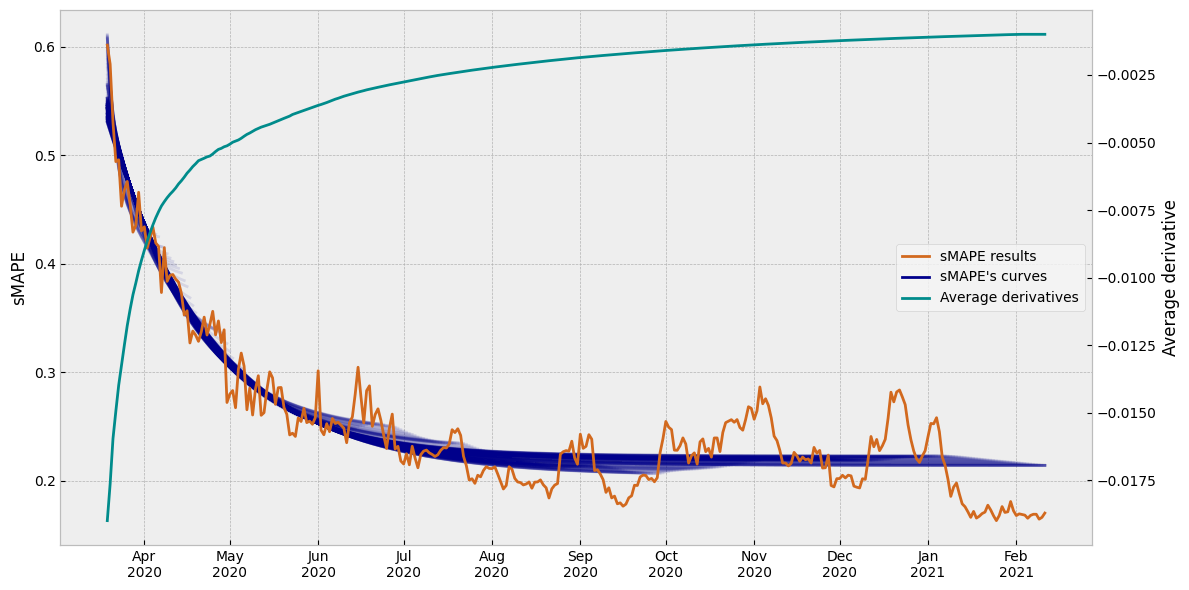

In [10]:
# Plot the average derivatives curve
fig, ax1 = plt.subplots(figsize=(12,6))
for curve in curves:
    ax1.plot(xfinal[:len(curve)], curve, color='darkblue', alpha=0.1)
ax1.plot(xfinal, yfinal, color='chocolate', label='sMAPE results')
ax1.plot([], color='darkblue', label="sMAPE's curves")
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.set_ylabel('sMAPE')
ax2 = ax1.twinx()
ax2.plot(xfinal, derivatives, color='darkcyan', label='Average derivatives')
ax2.set_ylabel('Average derivative')
fig.tight_layout()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=5, facecolor='whitesmoke')
ax2.grid(None)
plt.savefig('/graphs/Fig7.png', dpi=600)
plt.show()

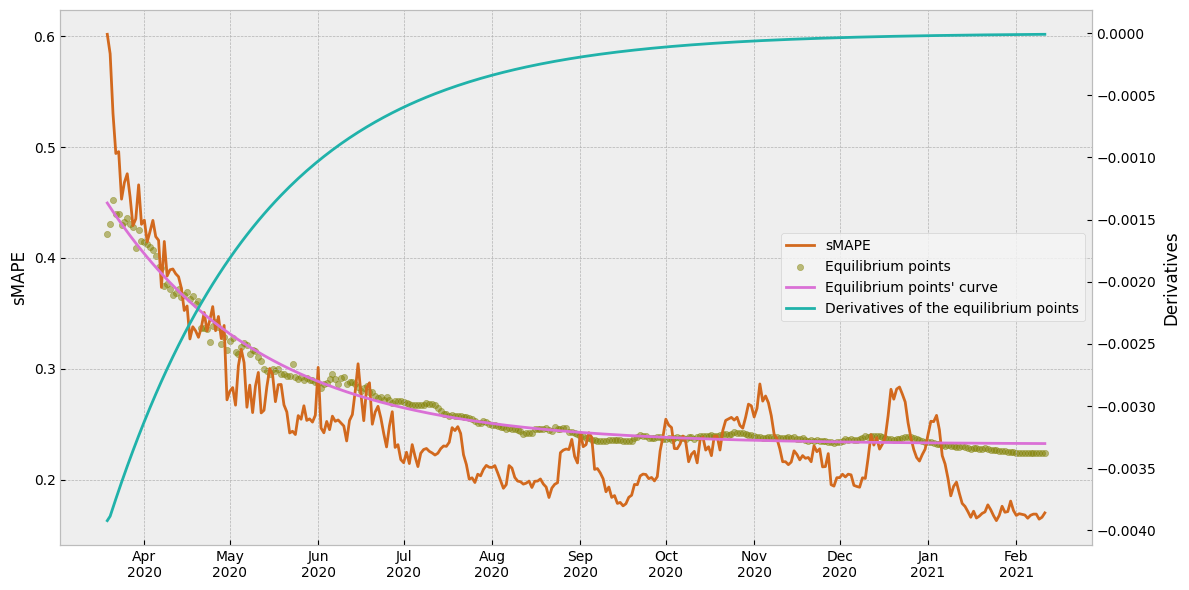

In [11]:
# Plot the equilibrium point curve and the derivatives
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(xfinal, yfinal, color='chocolate', label='sMAPE')
ax1.scatter(xfinal, limits, color='olive', label='Equilibrium points', alpha=0.5, s=20)
ax1.plot(xfinal, curve_limits, color='orchid', label="Equilibrium points' curve")
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.set_ylabel('sMAPE')
ax2 = ax1.twinx()
ax2.plot(xfinal, deriv_limits, color='lightseagreen', label='Derivatives of the equilibrium points')
ax2.set_ylabel('Derivatives')
fig.tight_layout()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=5, facecolor='whitesmoke')
ax2.grid(None)
plt.savefig('/graphs/Fig8.png', dpi=600)
plt.show()

In [12]:
# Calculate the average derivatives and equilibrium points from first 25% curves
# The experiment is repeated to ensure no data interference
range_limit = int(len(ydata) * 0.25)
y_data = ydata[:range_limit]

derivatives = []
limits = []
curves = []

for i in range(delta, len(y_data)):
    y = y_data[delta:(i + delta)]
    curve = exp_fit(y)
    derivative = calculate_average_derivative(curve)
    y_lim = equilibrium(y)
    curves.append(curve)
    derivatives.append(derivative)
    limits.append(y_lim)
yfinal = y
xfinal = xdata[delta:range_limit]

curve_limits = exp_fit(limits)
deriv_limits = np.gradient(curve_limits)

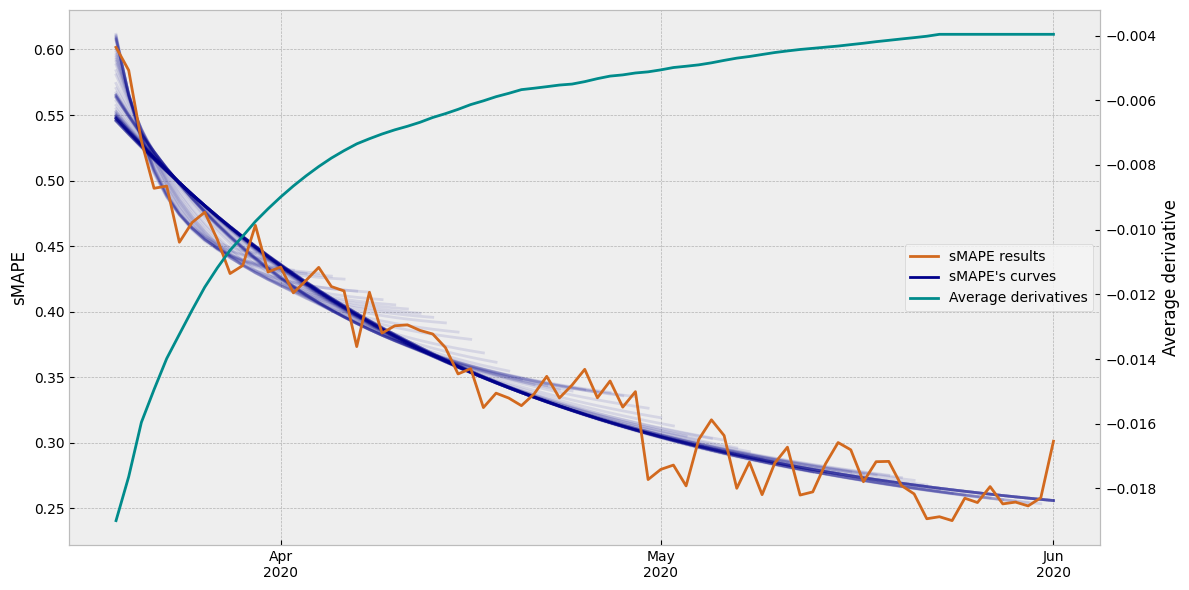

In [13]:
# Plot the average derivatives curve from first 25% curves
fig, ax1 = plt.subplots(figsize=(12,6))
for curve in curves:
    ax1.plot(xfinal[:len(curve)], curve, color='darkblue', alpha=0.1)
ax1.plot(xfinal, yfinal, color='chocolate', label='sMAPE results')
ax1.plot([], color='darkblue', label="sMAPE's curves")
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.set_ylabel('sMAPE')
ax2 = ax1.twinx()
ax2.plot(xfinal, derivatives, color='darkcyan', label='Average derivatives')
ax2.set_ylabel('Average derivative')
fig.tight_layout()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=5, facecolor='whitesmoke')
ax2.grid(None)
plt.savefig('/graphs/Fig9a.png', dpi=600)
plt.show()

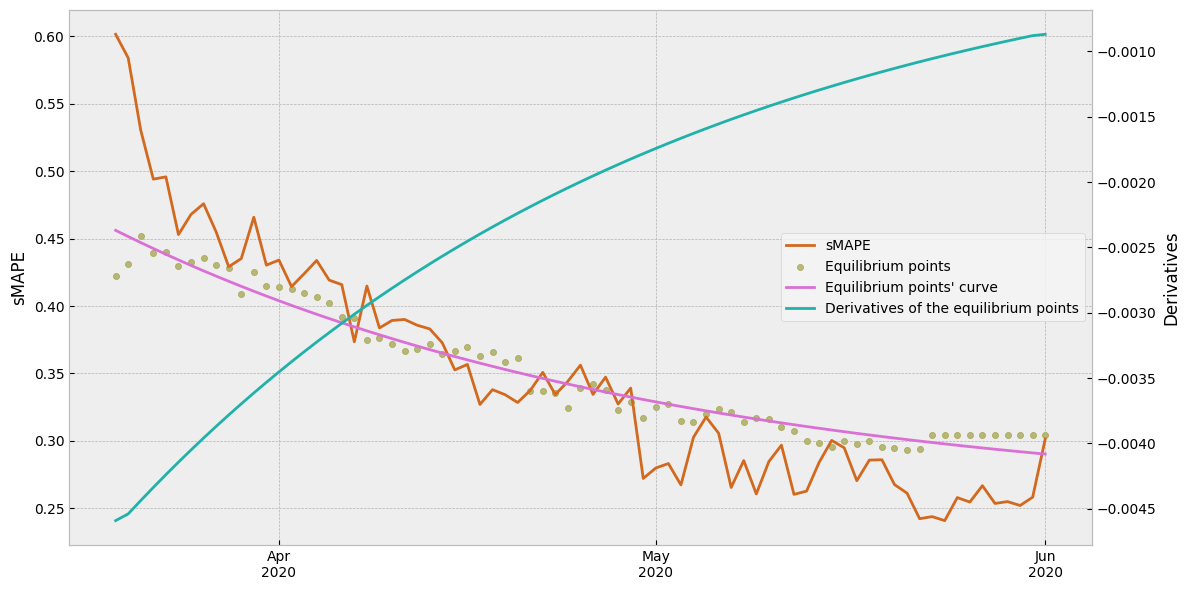

In [14]:
# Plot the equilibrium point curve and the derivatives from first 25% curves
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(xfinal, yfinal, color='chocolate', label='sMAPE')
ax1.scatter(xfinal, limits, color='olive', label='Equilibrium points', alpha=0.5, s=20)
ax1.plot(xfinal, curve_limits, color='orchid', label="Equilibrium points' curve")
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.set_ylabel('sMAPE')
ax2 = ax1.twinx()
ax2.plot(xfinal, deriv_limits, color='lightseagreen', label='Derivatives of the equilibrium points')
ax2.set_ylabel('Derivatives')
fig.tight_layout()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=5, facecolor='whitesmoke')
ax2.grid(None)
plt.savefig('/graphs/Fig9b.png', dpi=600)
plt.show()

In [15]:
# Calculate the average derivatives and equilibrium points from first 50% curves
# The experiment is repeated to ensure no data interference
range_limit = int(len(ydata) * 0.50)
y_data = ydata[:range_limit]

derivatives = []
limits = []
curves = []

for i in range(delta, len(y_data)):
    y = y_data[delta:(i + delta)]
    curve = exp_fit(y)
    derivative = calculate_average_derivative(curve)
    y_lim = equilibrium(y)
    curves.append(curve)
    derivatives.append(derivative)
    limits.append(y_lim)
yfinal = y
xfinal = xdata[delta:range_limit]

curve_limits = exp_fit(limits)
deriv_limits = np.gradient(curve_limits)

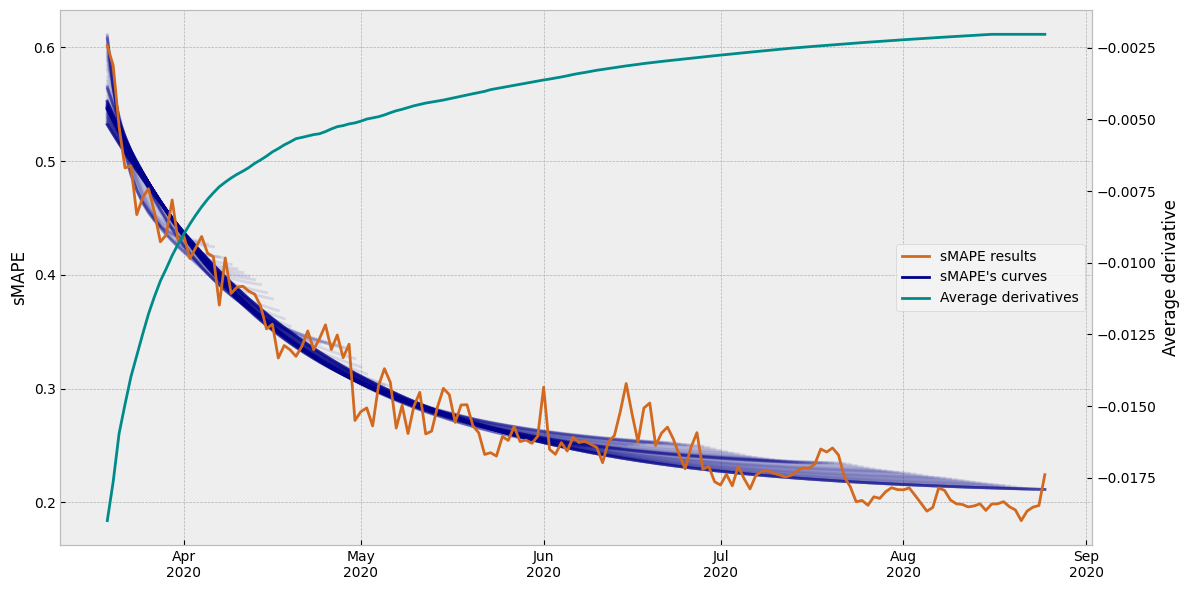

In [16]:
# Plot the average derivatives curve from first 50% curves
fig, ax1 = plt.subplots(figsize=(12,6))
for curve in curves:
    ax1.plot(xfinal[:len(curve)], curve, color='darkblue', alpha=0.1)
ax1.plot(xfinal, yfinal, color='chocolate', label='sMAPE results')
ax1.plot([], color='darkblue', label="sMAPE's curves")
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.set_ylabel('sMAPE')
ax2 = ax1.twinx()
ax2.plot(xfinal, derivatives, color='darkcyan', label='Average derivatives')
ax2.set_ylabel('Average derivative')
fig.tight_layout()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=5, facecolor='whitesmoke')
ax2.grid(None)
plt.savefig('/graphs/Fig9c.png', dpi=600)
plt.show()

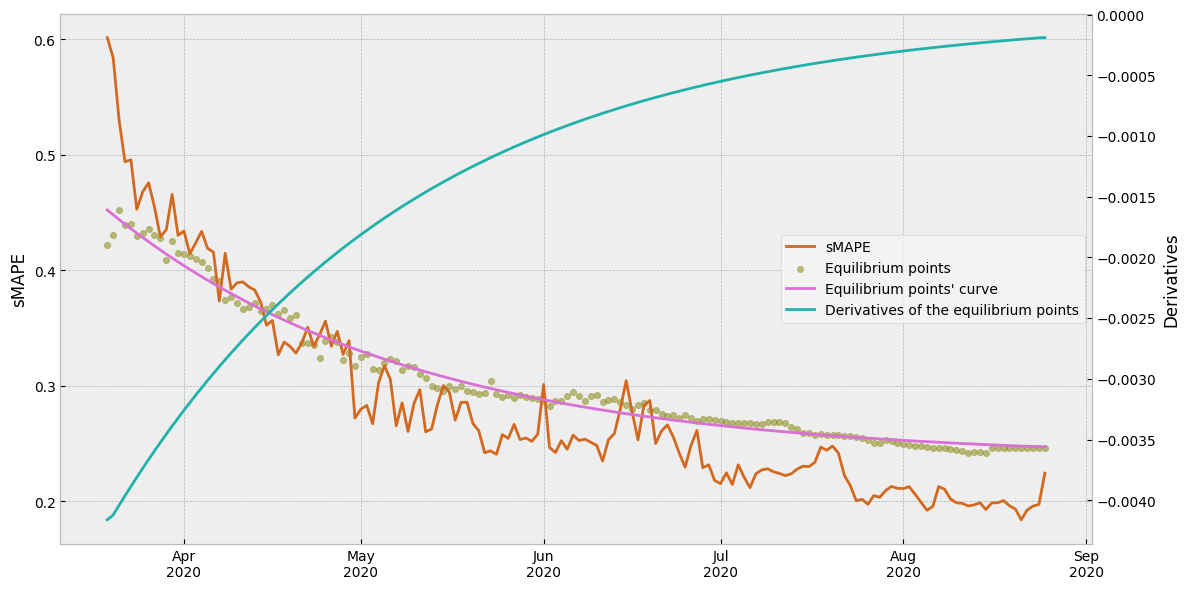

In [17]:
# Plot the equilibrium point curve and the derivatives from first 50% curves
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(xfinal, yfinal, color='chocolate', label='sMAPE')
ax1.scatter(xfinal, limits, color='olive', label='Equilibrium points', alpha=0.5, s=20)
ax1.plot(xfinal, curve_limits, color='orchid', label="Equilibrium points' curve")
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.set_ylabel('sMAPE')
ax2 = ax1.twinx()
ax2.plot(xfinal, deriv_limits, color='lightseagreen', label='Derivatives of the equilibrium points')
ax2.set_ylabel('Derivatives')
fig.tight_layout()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=5, facecolor='whitesmoke')
ax2.grid(None)
plt.savefig('/graphs/Fig9d.png', dpi=600)
plt.show()

In [18]:
# Calculate the average derivatives and equilibrium points from first 75% curves
# The experiment is repeated to ensure no data interference
range_limit = int(len(ydata) * 0.75)
y_data = ydata[:range_limit]

derivatives = []
limits = []
curves = []

for i in range(delta, len(y_data)):
    y = y_data[delta:(i + delta)]
    curve = exp_fit(y)
    derivative = calculate_average_derivative(curve)
    y_lim = equilibrium(y)
    curves.append(curve)
    derivatives.append(derivative)
    limits.append(y_lim)
yfinal = y
xfinal = xdata[delta:range_limit]

curve_limits = exp_fit(limits)
deriv_limits = np.gradient(curve_limits)

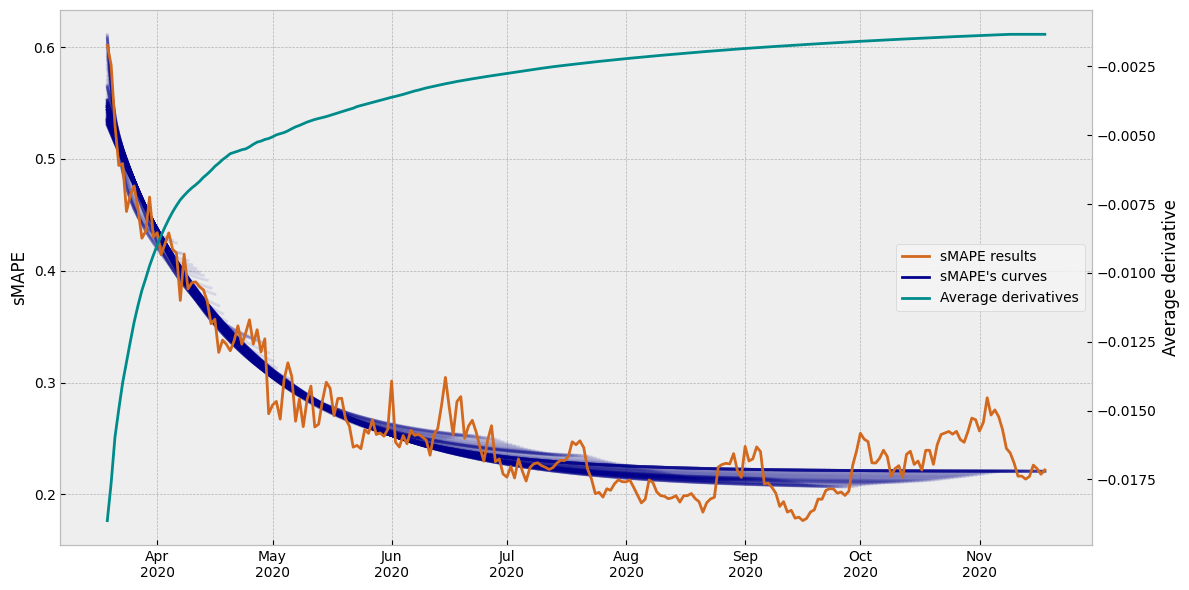

In [19]:
# Plot the average derivatives curve from first 75% curves
fig, ax1 = plt.subplots(figsize=(12,6))
for curve in curves:
    ax1.plot(xfinal[:len(curve)], curve, color='darkblue', alpha=0.1)
ax1.plot(xfinal, yfinal, color='chocolate', label='sMAPE results')
ax1.plot([], color='darkblue', label="sMAPE's curves")
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.set_ylabel('sMAPE')
ax2 = ax1.twinx()
ax2.plot(xfinal, derivatives, color='darkcyan', label='Average derivatives')
ax2.set_ylabel('Average derivative')
fig.tight_layout()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=5, facecolor='whitesmoke')
ax2.grid(None)
plt.savefig('/graphs/Fig9e.png', dpi=600)
plt.show()

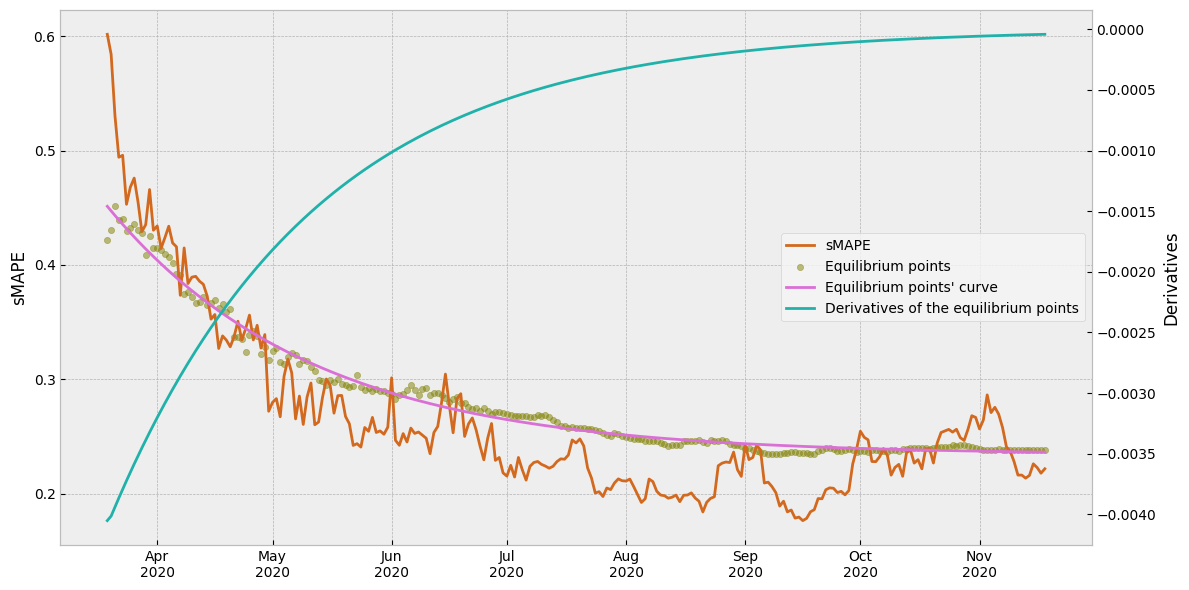

In [20]:
# Plot the equilibrium point curve and the derivatives from first 75% curves
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(xfinal, yfinal, color='chocolate', label='sMAPE')
ax1.scatter(xfinal, limits, color='olive', label='Equilibrium points', alpha=0.5, s=20)
ax1.plot(xfinal, curve_limits, color='orchid', label="Equilibrium points' curve")
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.set_ylabel('sMAPE')
ax2 = ax1.twinx()
ax2.plot(xfinal, deriv_limits, color='lightseagreen', label='Derivatives of the equilibrium points')
ax2.set_ylabel('Derivatives')
fig.tight_layout()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=5, facecolor='whitesmoke')
ax2.grid(None)
plt.savefig('/graphs/Fig9f.png', dpi=600)
plt.show()

In [21]:
# Calculate the average derivatives and equilibrium points from curves at equilibrium point
# The experiment is repeated to ensure no data interference
range_limit = 125
y_data = ydata[:range_limit]

derivatives = []
limits = []
curves = []

for i in range(delta, len(y_data)):
    y = y_data[delta:(i + delta)]
    curve = exp_fit(y)
    derivative = calculate_average_derivative(curve)
    y_lim = equilibrium(y)
    curves.append(curve)
    derivatives.append(derivative)
    limits.append(y_lim)
yfinal = y
xfinal = xdata[delta:range_limit]

curve_limits = exp_fit(limits)
deriv_limits = np.gradient(curve_limits)

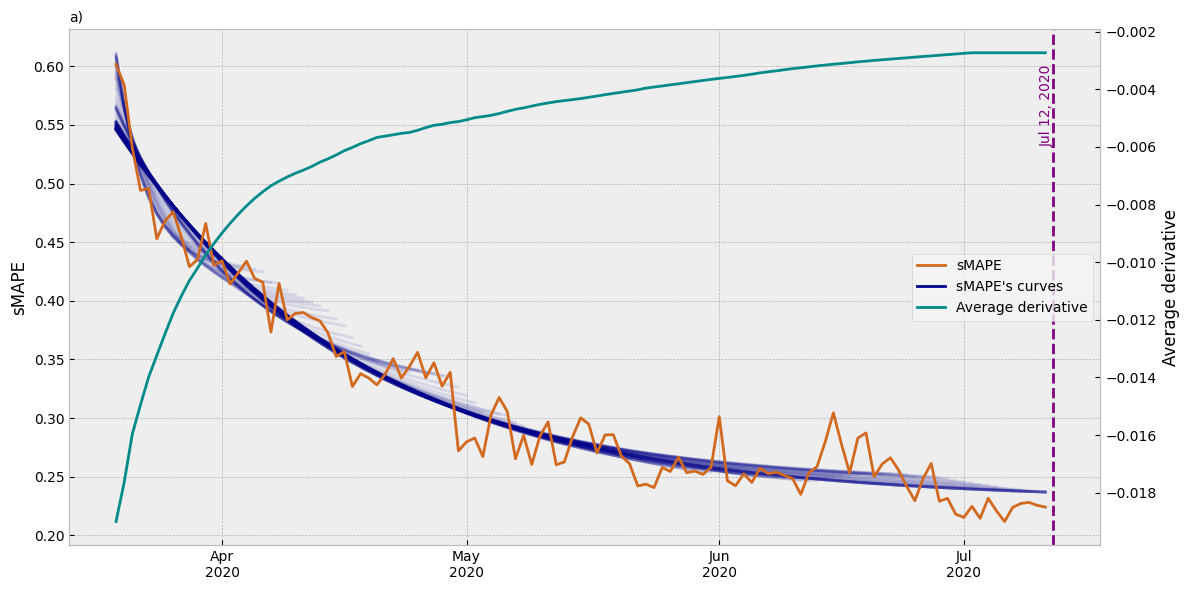

In [22]:
fig, ax1 = plt.subplots(figsize=(12,6))
for curve in curves:
    ax1.plot(xfinal[:len(curve)], curve, color='darkblue', alpha=0.1)
ax1.plot(xfinal, yfinal, color='chocolate', label='sMAPE')
ax1.plot([], color='darkblue', label="sMAPE's curves")
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.set_ylabel('sMAPE')
ax1.set_title('a)', fontsize=10, loc='left')
ax1.axvline(x=xdata[range_limit], color='purple', linestyle='--')
ax1.text(xdata[range_limit], np.max(yfinal), 'Jul 12, 2020', color='purple',
         ha='right', va='top', rotation=90)
ax2 = ax1.twinx()
ax2.plot(xfinal, derivatives, color='darkcyan', label='Average derivative')
ax2.set_ylabel('Average derivative')
fig.tight_layout()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=5, facecolor='whitesmoke')
ax2.grid(None)
plt.savefig('/graphs/Fig10a.png', dpi=600)
plt.show()

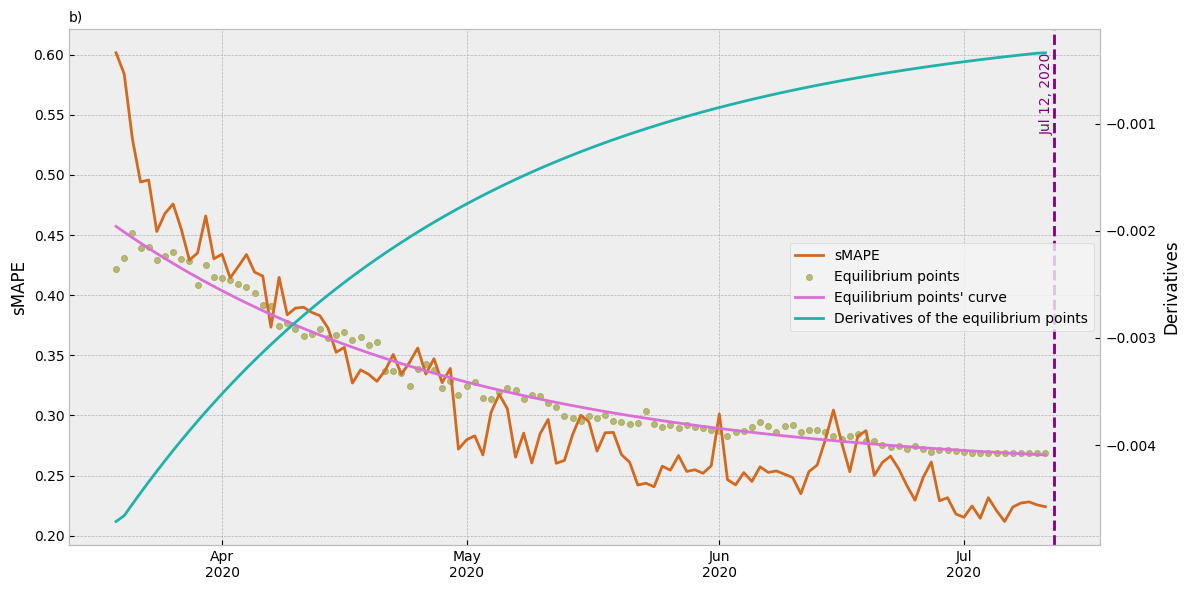

In [23]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(xfinal, yfinal, color='chocolate', label='sMAPE')
ax1.scatter(xfinal, limits, color='olive', label='Equilibrium points', alpha=0.5, s=20)
ax1.plot(xfinal, curve_limits, color='orchid', label="Equilibrium points' curve")
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.set_ylabel('sMAPE')
ax1.set_title('b)', fontsize=10, loc='left')
ax1.axvline(x=xdata[range_limit], color='purple', linestyle='--')
ax1.text(xdata[range_limit], np.max(yfinal), 'Jul 12, 2020', color='purple',
         ha='right', va='top', rotation=90)
ax2 = ax1.twinx()
ax2.plot(xfinal, deriv_limits, color='lightseagreen', label='Derivatives of the equilibrium points')
ax2.set_ylabel('Derivatives')
fig.tight_layout()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=5, facecolor='whitesmoke')
ax2.grid(None)
plt.savefig('/graphs/Fig10b.png', dpi=600)
plt.show()